# IRCADb Segmentation

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IRCADb-Segmentation" data-toc-modified-id="IRCADb-Segmentation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IRCADb Segmentation</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Code</a></span></li></ul></li></ul></div>

## Resources
* Article: 
    * https://medium.com/@fabio.sancinetti/u-net-convnet-for-ct-scan-segmentation-6cc0d465eed3
* Dataset:
    * https://www.ircad.fr/research/3d-ircadb-01/
* CUDA:
    * https://stackoverflow.com/questions/51111954/tensorflow-cant-find-cudart64-90-dll-even-though-it-is-installed-with-path-va

## Imports

In [1]:
# Imports jtplot submodule from jupyterthemes, sets notebook theme for plots.
# Nice to have if you are using jupyterthemes, otherwise ignore this. 
try:
    __import__('imp').find_module('jupyterthemes')
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass

# General imports
import os, re
import pydicom as dicom
from scipy.ndimage.interpolation import zoom        
from random import shuffle
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning imports
import tensorflow as tf
import keras
from keras import backend as K
from keras import losses
from keras.models import Model, Sequential
from keras.objectives import categorical_crossentropy
from keras.layers import Input, concatenate
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, Conv2DTranspose, ZeroPadding2D
from keras.optimizers import Adam, Adadelta, Adamax, Nadam, Adagrad, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback
from keras.initializers import RandomUniform, RandomNormal

Using TensorFlow backend.


## Code

In [78]:
zz = 'data\3Dircadb1.13\MASKS_DICOM\livertumor\image_37'
zz2 = zz.split('\\')
zz2[2]

'livertumor'

In [83]:
class PatientData(object):
    """
    
    PatientData looks for files of 3DIRCAD database.
    This database contains DICOM files and data is split into folders.
    PATIENT_DICOM folder contains original original CT Images
    MASKS_DICOM contains a list of several folders. Each folder is named
    according to the organ highlighted in the masks of the files within.
    During PatientData initialization, it will look for the folder pointed at
    root_dir and will load files named with same name on MASKS_DICOM/<organ name>/*
    
    """
    def __init__(self, root_dir, oi, file_extension=".dcm"):
        patient_images = {}

        for root, dirs, files in os.walk(root_dir):
            #print('\nroot:', root)
            #print('dirs:', dirs)
            #print('files:', files)
            for file in files:
                if file.endswith(file_extension):
                    if 'PATIENT_DICOM' in root:
                        if not patient_images.get(file,None):
                            patient_images[file] = {}
                        p = os.path.join(root,file)
                        patient_images[file]['real'] = p
                    elif 'MASKS_DICOM' in root:
                        if not patient_images.get(file,None):
                            patient_images[file] = {}
                        p = os.path.join(root,file)
                        #rs = re.match('.*MASKS_DICOM/(.*)/.*', str(p))
                        rs = p.split('\\')
                        rs = rs[2]
                        print(rs)
                        #print('p:', p)
                        #print('rs:', rs)
                        
                        #patient_images[file][rs.groups()[0]] = p
                        patient_images[file][rs] = p

        self.oi = oi
        self.X = []
        self.Y = []
        
        for k,v in patient_images.items():
            for k1,v1 in v.items():
                if k1 == self.oi:
                    self.X.append(v['real'])
                    self.Y.append(v1)
        
        if len(self.X) != len(self.Y):
            raise Exception("number of input images (%d) does not match number of training samples (%d)" % 
                            (len(self.X),len(self.Y)))
   
            
    def normalize(self, img):
        arr = img.copy().astype(np.float)
        M = np.float(np.max(img))
        if M != 0:
            arr *= 1./M
        return arr
    

    def add_gauss_noise(self, inp, expected_noise_ratio=0.05):
        image = inp.copy()
        if len(image.shape) == 2:
            row,col= image.shape
            ch = 1
        else:
            row,col,ch= image.shape
        mean = 0.
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col)) * expected_noise_ratio
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy

    def get_data(self, noisy=False, split_part=0.5, resize_side=None, verbose=False):
        im_X = []
        im_Y = []
        for i in range(len(self.X)):
            img_x = dicom.read_file(self.X[i]).pixel_array
            img_y = dicom.read_file(self.Y[i]).pixel_array
            if resize_side != None:
                ratio = resize_side / 512.
                img_x = zoom(img_x, ratio).copy()
                img_y = zoom(img_y, ratio).copy()
            img_x = self.normalize(img_x)
            img_y = self.normalize(img_y)

            if np.sum(img_y) < 5.:
                if np.random.randint(1,10) <= 5:
                    if verbose:
                        print("discarding a very zero like image %s (%f)" % (self.Y[i],np.sum(img_y)))
                    continue
            if noisy:
                img_x = self.add_gauss_noise(img_x)
                img_y = self.add_gauss_noise(img_y)
            im_X.append(img_x)
            im_Y.append(img_y)
            
        train_limit = int(len(im_X)*split_part)

        indexes = list(range(len(im_X)))
        shuffle(indexes)            

        shuffleX = [im_X[c] for c in indexes]
        shuffleY = [im_Y[c] for c in indexes]

        train_x = shuffleX[0:train_limit]
        test_x = shuffleX[train_limit:]
        train_y = shuffleY[0:train_limit]
        test_y = shuffleY[train_limit:]
        
        return train_x, train_y, test_x, test_y

In [84]:
root_dir = "data/"

sample_height, sample_width = (128,128)
output_width, output_height = (128, 128)
img_tot_size = sample_width*sample_height

sess = tf.Session()
K.set_session(sess)

pd = PatientData(root_dir, 'bone', file_extension="") # Also works for 'liver'

data = pd.get_data(False, 0.75, sample_width) # Using 75% for training
train_x, train_y, test_x, test_y = map(np.array, data)
print("Using %s images for training and %s images for testing" % (len(train_x), len(test_x)))

artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bo

livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor06
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07
livertumor07

bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver


venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
venacava
v

artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
artery
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
b

skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
venoussystem
ven

livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
livertumor2
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein
portalvein


liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
live

colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colon
colo

liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
liver
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lungs
lung

rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
rightkidney
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin

surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surrenalgland
surren

kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys
kidneys


spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones
Stones

leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftsurrenalgland
leftsurrenalgland
leftsurrenalgland
leftsurrenalgland
leftsurrenalgland
leftsurrenalgland
leftsurrenalgland
leftsurrenalgland
leftsurrenalgland
leftsurrenalgland
leftsurrenalgland
leftsurrenalgland
leftsurrenalgland
leftsur

rightsurretumor
rightsurretumor
rightsurretumor
rightsurretumor
rightsurretumor
rightsurretumor
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
skin
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen
spleen

bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftkidney
leftki

rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung
rightlung


bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
bone
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbladder
gallbla

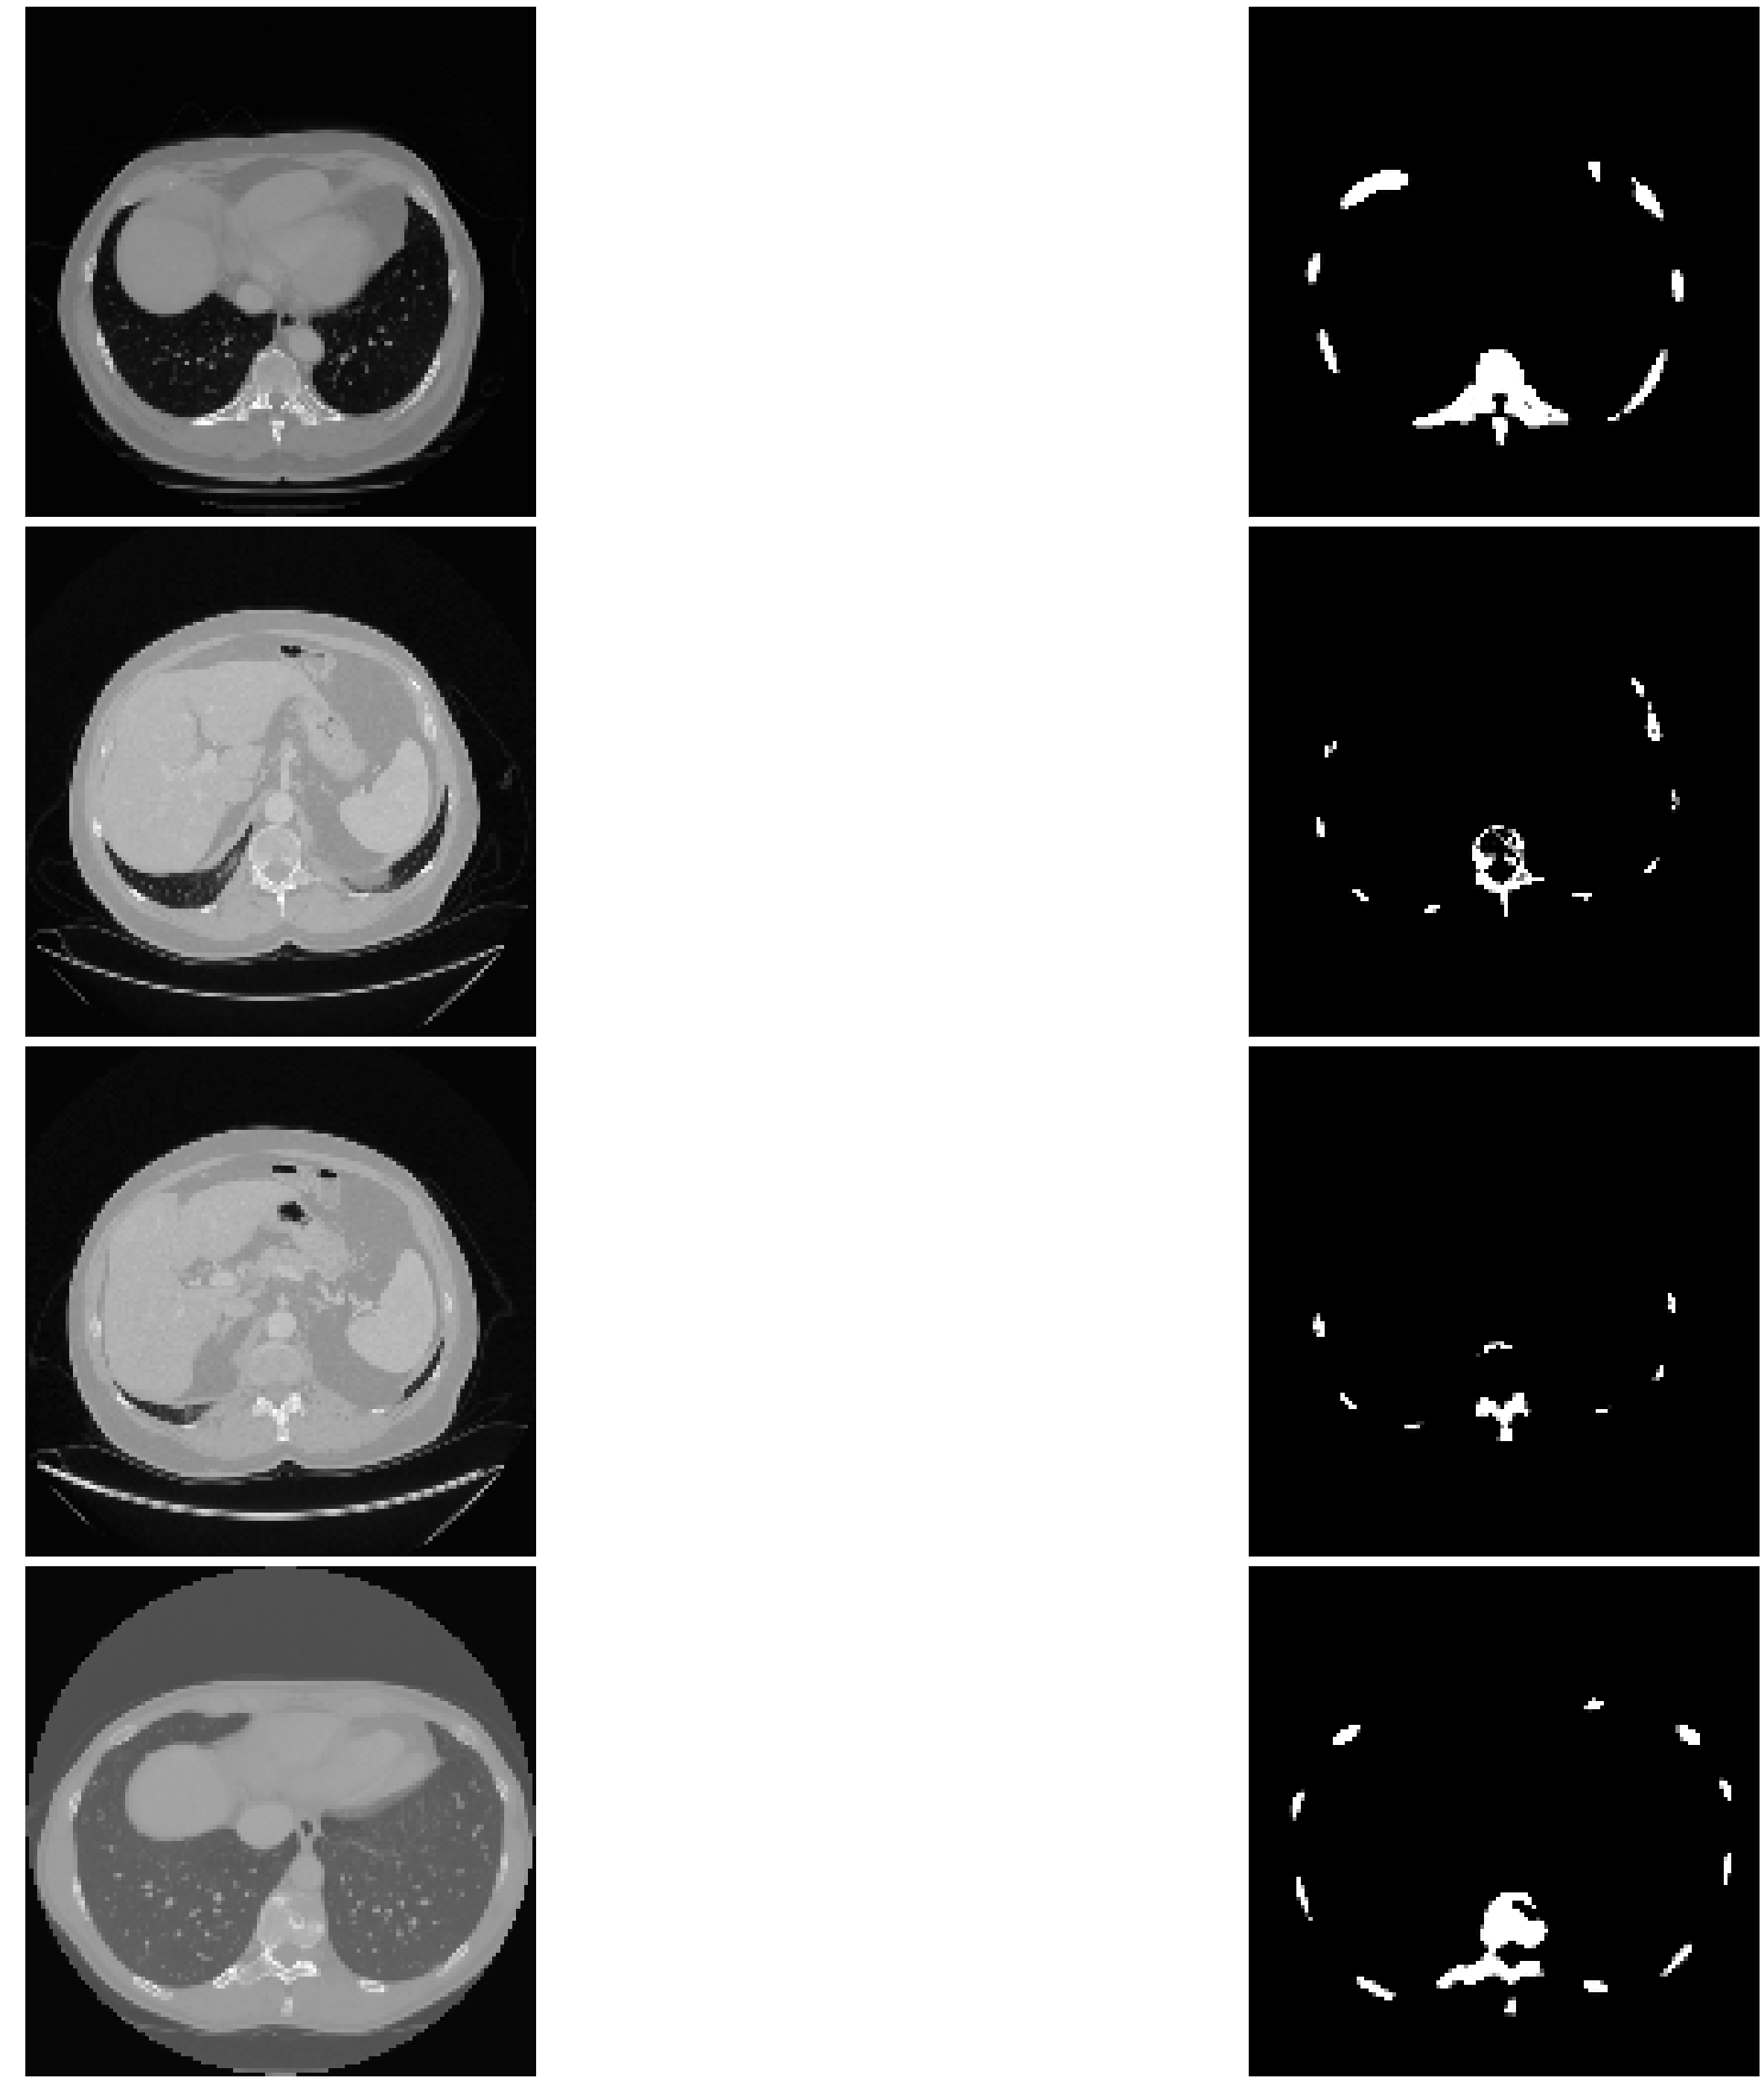

In [85]:
# Displaying some samples of the input
lines = min(4,len(train_x)) # len(imgs_mask_test) #16
fig, axarr = plt.subplots(lines, 2, figsize=(60,lines*10), sharex=True, sharey=False)

tot_dice = 0.
for i in range(0,lines):
    
    axarr[i,0].imshow(train_x[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,1].imshow(train_y[i].reshape(output_width, output_height), cmap='gray')
    
    for x in range(2):
        axarr[i,x].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.975)
plt.show()

In [86]:
train_x = np.array([t.reshape(sample_width, sample_height,1) for t in train_x])
train_y = np.array([t.reshape(sample_width, sample_height,1) for t in train_y])
test_x  = np.array([t.reshape(sample_width, sample_height,1) for t in test_x])
test_y  = np.array([t.reshape(sample_width, sample_height,1) for t in test_y])

In [87]:
def get_model(optimizer, loss_metric, metrics, lr=1e-3):
    inputs = Input((sample_width, sample_height, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.3)(pool3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.3)(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # working with dice and adam
    model.compile(optimizer=Adam(lr=1e-3, decay=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    
    #Adamax
    #model.compile(optimizer=Adamax(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    
    #SGD
    #model.compile(optimizer=SGD(lr=1e-2, momentum=0.8), loss=dice_coef_loss, metrics=[dice_coef])
    
    #Nadam
    #model.compile(optimizer=Nadam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    
    #Adadelta
    #model.compile(optimizer=Nadam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    
    return model

In [88]:
smooth = 1.

# Dice Coefficient to work with Tensorflow
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Dice Coefficient to work outside Tensorflow
def dice_coef_2(y_true, y_pred):
    side = len(y_true[0])
    y_true_f = y_true.reshape(side*side)
    y_pred_f = y_pred.reshape(side*side)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)
    

In [89]:
model = get_model(optimizer=Adam, loss_metric=dice_coef_loss, metrics=[dice_coef], lr=1e-3)

W0628 06:04:15.528549 25528 deprecation_wrapper.py:119] From C:\Users\Andy\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 06:04:15.530550 25528 deprecation_wrapper.py:119] From C:\Users\Andy\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 06:04:15.534548 25528 deprecation_wrapper.py:119] From C:\Users\Andy\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 06:04:15.566539 25528 deprecation_wrapper.py:119] From C:\Users\Andy\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0628 06:04:15.570536 25528 deprecation_wrapper.py:119] From C:\Users\Andy\Anaconda

In [90]:
observe_var = 'dice_coef'
strategy = 'max' # greater dice_coef is better

#observe_var = 'loss' # for binary crossentropy 
#strategy = 'in' # smallest loss is better

#model_checkpoint = ModelCheckpoint('ptc5750.h5', monitor=observe_var, save_best_only=True)
#model_reset = ObserveTrainingFailure(observe_var,strategy, -1 , 10)



In [91]:
start_time = time.time()

history = model.fit(train_x, train_y, batch_size=int(len(train_x)/4),
          epochs=150, verbose=1, shuffle=True, validation_split=0.2)


elapsed_time = time.time() - start_time
print("Elapsed time: ", elapsed_time)

W0628 06:04:23.817218 25528 deprecation_wrapper.py:119] From C:\Users\Andy\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 156 samples, validate on 39 samples
Epoch 1/150


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
	 [[metrics/dice_coef/Mean/_397]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
print(history.history.keys())

In [ ]:
# list all data in history

# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.title('Model Accuracy')
plt.ylabel('Dice Coef.')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
imgs_mask_test = model.predict(test_x, verbose=1)

tot_dice = 0.
dices = []
for i in range(len(imgs_mask_test)):
    r = dice_coef_2(test_y[i],imgs_mask_test[i])
    dices.append(r)
    tot_dice += r
    
avg_dice = tot_dice/float(len(imgs_mask_test))
print(avg_dice)

In [ ]:

postProcess = True
if postProcess:        
    avg = np.average(imgs_mask_test)
    for k in range(len(imgs_mask_test)):
        im = imgs_mask_test[k]
        m = np.max(im)
        for i in range(len(im)):
            for j in range(len(im[i])):
                # remove low confidence results helps to increase dice result
                if im[i,j] < (0.5):
                    im[i,j] = 0.
    
    tot_dice = 0.
    dices = []
    for i in range(len(imgs_mask_test)):
        r = dice_coef_2(test_y[i],imgs_mask_test[i])
        dices.append(r)
        tot_dice += r
        

    avg_dice = tot_dice/float(len(imgs_mask_test))
    print(avg_dice)
                    

In [ ]:
# Displaying some results
lines = max(15,len(imgs_mask_test))
fig, axarr = plt.subplots(lines, 3, figsize=(60,lines*10), sharex=True, sharey=False)

output_width, output_height = (128, 128)
for i in range(0,lines):
    axarr[i,0].imshow(test_x[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,1].imshow(test_y[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,2].imshow(imgs_mask_test[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,2].set_title('Dice Coef = ' + str(dices[i]),fontsize=45,ha='center')
    
    for x in range(3):
        axarr[i,x].axis('off')

fig.suptitle('Dice average = ' + str(avg_dice) ,fontsize=60)
fig.tight_layout()
fig.subplots_adjust(top=0.975)
plt.show()